<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

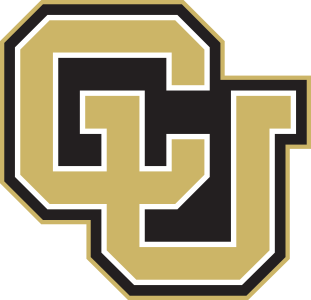

# Lecture 03, hands-on: $K$-Means
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Goals
* Identify the components of an unsupervised learning problem.
* Use sklearn for clustering analysis and familiarize yourself with the API.
* Basic understanding of centroid-based algorithms ($k$-means) and other algorithms.
* Clustering in practice: feature scaling and interpretability.

# Reading Material

Check out different resources and documentation from sklearn.

* [Clustering guide](https://scikit-learn.org/1.5/modules/clustering.html) from sklearn:
  * Introduction to **different clustering methods**.
  * Clustering **performance evaluation**:
    * **When we know** the ground-truth (external metrics):
      * Based on Rand Index, such as ARI.
      * Based on mutual information, such as NMI.
    * **When we don't know** the ground-truth (internal metrics):
      * Silhouette coefficient
      * Calinski-Harabasz Index
      * Davies-Bouldin Index

# Modules

In [6]:
# load modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset 1

Load dataset. Feature names have the format `f[NUMBER]`. The column "labels", if present, contains the true labels/clusters.

In [35]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/8elyky9mtq9nser82xk05/dataset01.tsv?rlkey=wlue2ejkkyen8ghdxah6yqso2&st=n9x9muq9&dl=1",
    sep="\t",
)

## Question 1

How many objects ($n$) and features ($d$) are in this dataset?

In [36]:
data.head()
#data.describe()
#data.info()
#data.shape

f1        f2        f3        f4        f5        f6        f7  \
0 -0.330916 -0.411204  1.806458  3.881925  1.703582  0.184864  1.565088   
1  0.005613 -0.003614  0.177467  2.373105  1.515870  2.381005  2.565380   
2 -0.050342 -0.338685  2.532612  0.597579  2.660178  2.668388  0.638148   
3  0.100639  0.693432  2.062112  2.031477  2.613821  3.768640  2.383001   
4 -0.160311 -0.576029  2.931509  1.552599  3.799989  1.763680  2.892516   

         f8        f9       f10       f11       f12  labels  
0  1.386821  1.942868  0.640872  1.592145  3.250613       1  
1  2.253157  2.118793  0.798179  0.824951  1.711693       1  
2  2.091127  2.294401  0.355153  0.134495  1.924682       1  
3  1.690449  1.502907  1.180356  0.706819  0.027658       1  
4  0.358567  2.479182  1.460836  3.351244  0.317846       1

_Answer_: There are 100 objects (n) and 12 features (d).

## Question 2

Does this dataset have the ground truth (or "true") labels/clusters?
How many clusters are present in this ground truth, and how many objects are in each "true" cluster?
If we ran a clustering algorithm on the data, which metrics can we use to measure performance given the data?

In [11]:
data["labels"].value_counts()

labels
1    25
2    25
3    25
4    25
Name: count, dtype: int64

_Answer_: Yes, this dataset has ground truth labels for the clusters. There are 4 clusters with 25 observations in each cluster. 

## Question 3

We want to understand whether there is some structure among the objects in the data.
Perform a cluster analysis using $K$-Means to answer the following questions:
1. Are there stable clusters in the data?
2. What are the optimal parameters of a $K$-Means model that maximize the agreement with the true labels? Use at least two different metrics to compare the true labels with the $K$-Means labels.
3. Do clustering solutions in 1. and 2. coincide? Why or why not?

   k    ARI    NMI  Silhouette
0  2  0.327  0.577       0.282
1  3  0.663  0.788       0.252
2  4  0.946  0.939       0.270
3  5  0.855  0.884       0.229
4  6  0.766  0.840       0.176
5  7  0.697  0.809       0.145

Best k (external metrics): 4
Best k (internal metric): 2
Solutions coincide: False


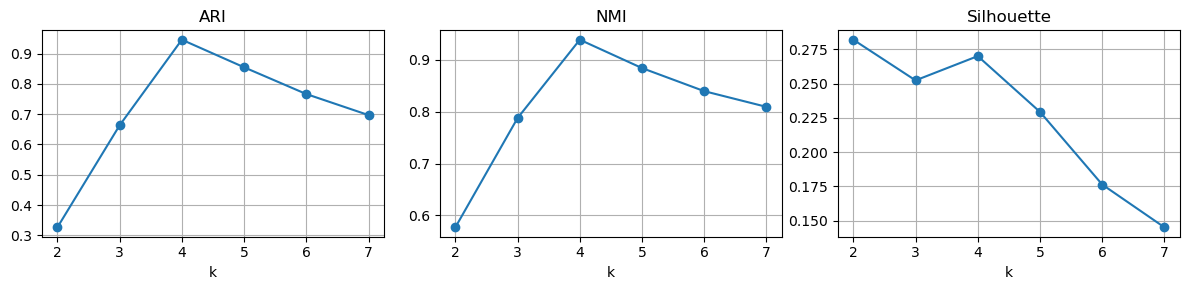

In [37]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score

X = data.drop('labels', axis=1)
true_labels = data['labels']

# test different k values
results = []
for k in range(2, 8):
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    pred_labels = model.fit_predict(X)
    
    results.append({
        'k': k,
        'ARI': adjusted_rand_score(true_labels, pred_labels),
        'NMI': normalized_mutual_info_score(true_labels, pred_labels),
        'Silhouette': silhouette_score(X, pred_labels)
    })

results_df = pd.DataFrame(results)
print(results_df.round(3))

# find best k values
best_k_external = results_df.loc[results_df['ARI'].idxmax(), 'k']
best_k_internal = results_df.loc[results_df['Silhouette'].idxmax(), 'k']

print(f"\nBest k (external metrics): {best_k_external}")
print(f"Best k (internal metric): {best_k_internal}")
print(f"Solutions coincide: {best_k_external == best_k_internal}")

fig, ax = plt.subplots(1, 3, figsize=(12, 3))
for i, metric in enumerate(['ARI', 'NMI', 'Silhouette']):
    ax[i].plot(results_df['k'], results_df[metric], 'o-')
    ax[i].set_title(metric)
    ax[i].set_xlabel('k')
    ax[i].grid(True)
plt.tight_layout()
plt.show()

_Answer_: 
1. Yes, there are 4 stable clusters in the data. 
2. The most optimal parameters for K-means is k=4 clusters. This is demonstrated by max ARI, NMI, and silhouette score at k=4.
3. Clustering solutions in 1. and 2. do agree. The dataset initially has 4 clusters indicated by the labels, and the K-means algorithm also found k=4 as the most optimal number of clusters to fit this dataset.

## Question 4

Use at least two internal metrics to measure the quality of the clustering solutions.

1. Do they match with the true labels? Why?
2. Do they match among themselves?

In [21]:
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

X = data.drop('labels', axis=1)
true_labels = data['labels']

# test different k values with silhousette and calinski-harabasz internal metrics
results = []
for k in range(2, 6):
    model = KMeans(n_clusters=k, random_state=42)
    pred_labels = model.fit_predict(X)
    
    results.append({
        'k': k,
        'Silhouette': silhouette_score(X, pred_labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, pred_labels),
        'Davies-Bouldin': davies_bouldin_score(X, pred_labels)
    })

df = pd.DataFrame(results)
print(df.round(3))

# find best k for each metric
best_sil = df.loc[df['Silhouette'].idxmax(), 'k']
best_ari = df.loc[df['Calinski-Harabasz'].idxmax(), 'k']
best_db = df.loc[df['Davies-Bouldin'].idxmin(), 'k']

print(f"\nBest k: Silhouette={best_sil}, Calinski-Harabasz={best_ari}, Davies-Bouldin={best_db}")
print(f"Internal matches external: {best_sil == best_ari == best_db}")

   k  Silhouette  Calinski-Harabasz  Davies-Bouldin
0  2       0.251             42.573           1.501
1  3       0.252             38.576           1.465
2  4       0.270             40.152           1.385
3  5       0.222             32.225           1.659

Best k: Silhouette=4, Calinski-Harabasz=2, Davies-Bouldin=4
Internal matches external: False


_Answer_: 
1. Partially yes. The silhouette score and calinski-harabasz score optimal k values were the same as the true labels. 
2. No, not all of the internal metrics match when determining the optimal number of k. The silhouette and davies-bouldin scores both determined k=4 to be optimal, however, the calinkski-harabasz scoring metric found 2 clusters to be optimal.

## Question 5

Explore the different features of the dataset and find the top ones that are most helpful to capture the true labels in the data. Answer the following questions:

1. Create 2D scatterplots of the data using all possible combinations of feature pairs. _Tip:_ Look at the [`pairplot`](https://seaborn.pydata.org/generated/seaborn.pairplot.html) function in `seaborn`.
1. What are the most important features that the algorithm used to accurately cluster the data? Are some features more important than others?
1. Create a 2-dimensional plot using the two top features you found. Include the true labels and centroids learned by $K$-Means using the $K$ with the most accurate solution. _Tip:_ the [`scatterplot`](https://seaborn.pydata.org/generated/seaborn.scatterplot.html) function from seaborn returns a matplotlib's Axes object that you can use to draw on top of the original plot.
1. Related to the second question: think about some approaches that could be used to automatically learn the most important features that are driving clustering results.

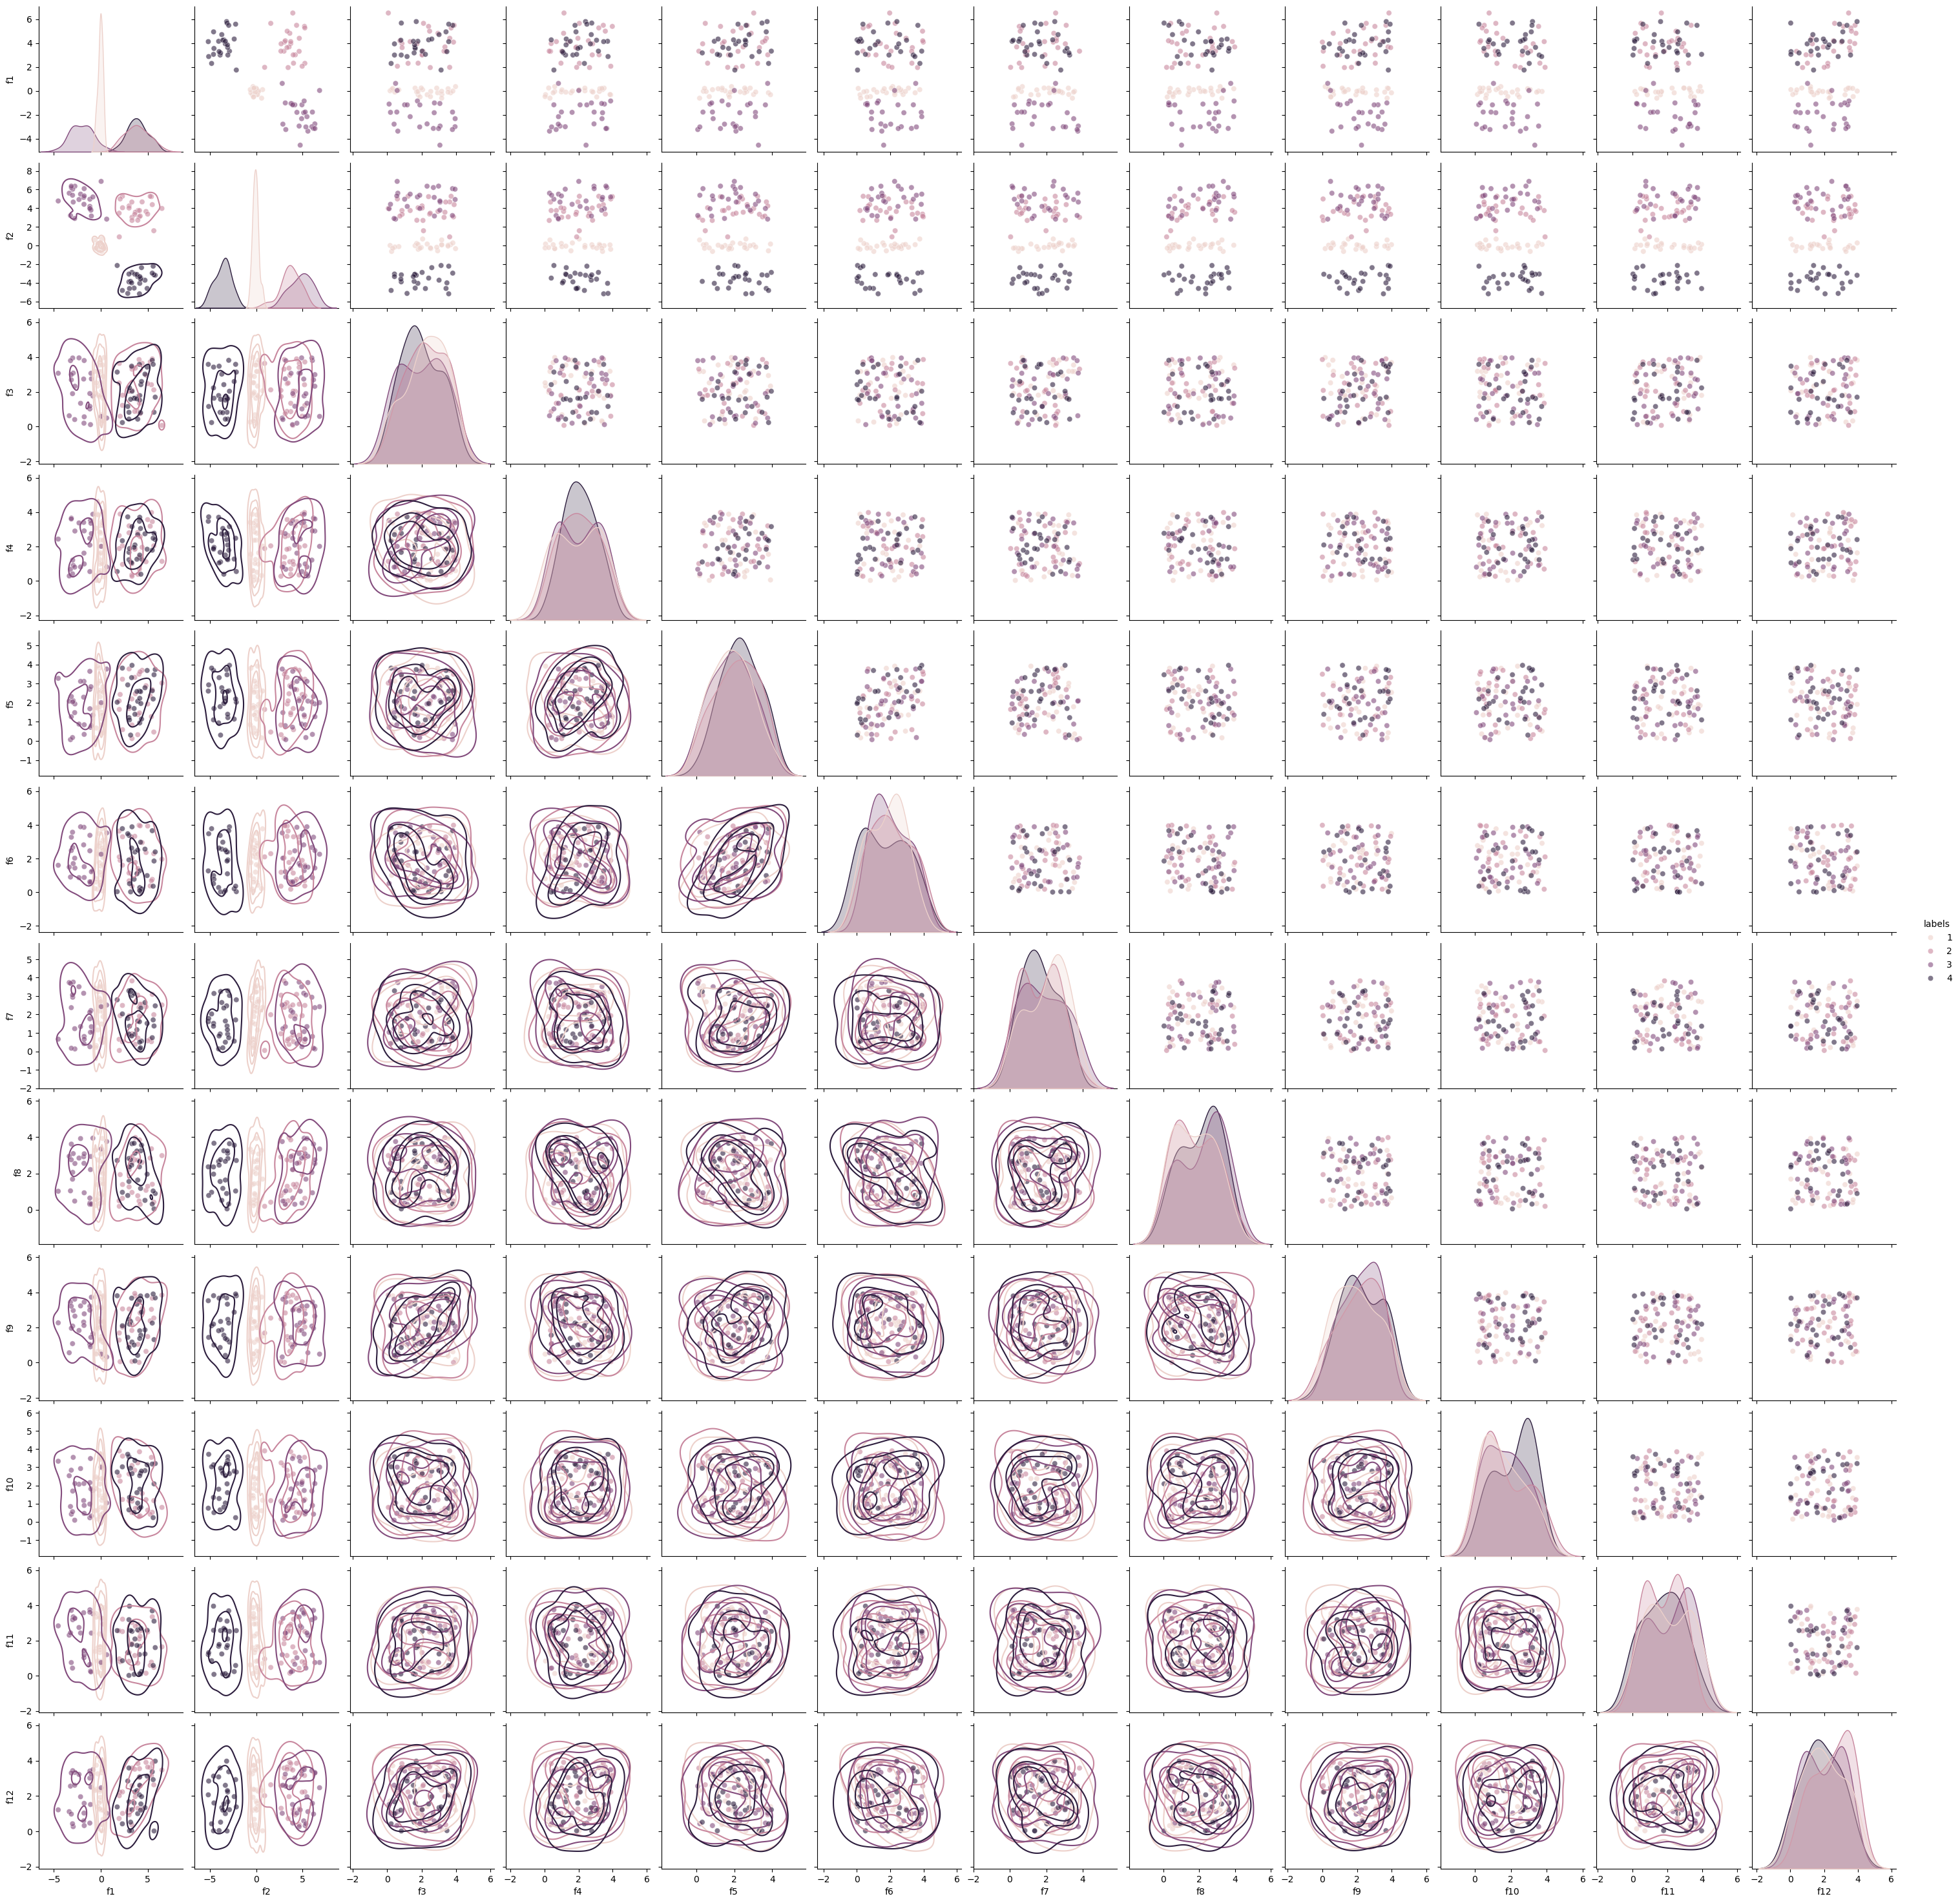

Best feature pair: ('f2', 'f3') (ARI: 0.683)


In [24]:
# pairplot to see all feature combinations
feature_cols = [col for col in data.columns if col.startswith('f')]
plot_data = data[feature_cols + ['labels']].copy()
g = sns.pairplot(plot_data, hue='labels', plot_kws={'alpha':0.6})
g.map_lower(sns.kdeplot, levels = 4)
plt.show()

# find best features by testing clustering on feature pairs
from itertools import combinations
best_score = 0
best_features = None

for f1, f2 in combinations(feature_cols, 2):
    X_pair = data[[f1, f2]]
    model = KMeans(n_clusters=3, random_state=42)
    pred = model.fit_predict(X_pair)
    score = adjusted_rand_score(data['labels'], pred)
    
    if score > best_score:
        best_score = score
        best_features = (f1, f2)

print(f"Best feature pair: {best_features} (ARI: {best_score:.3f})")


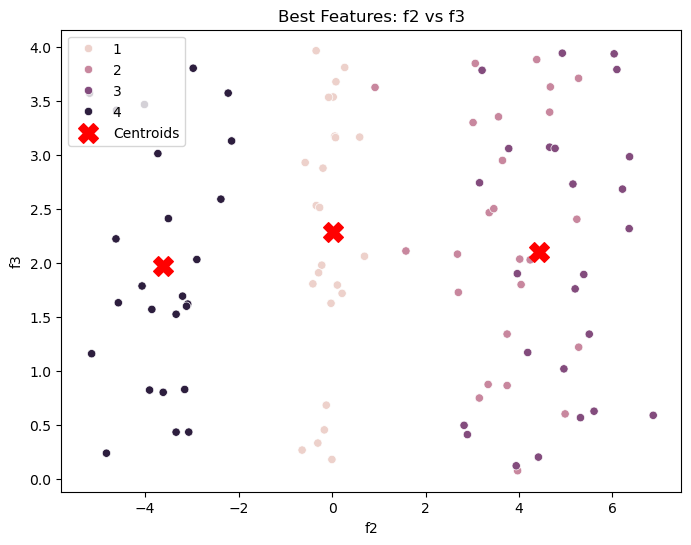

In [25]:


# plot best features with true labels and centroids
X_best = data[list(best_features)]
model = KMeans(n_clusters=3, random_state=42)
model.fit(X_best)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x=best_features[0], y=best_features[1], hue='labels')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], 
           c='red', marker='X', s=200, label='Centroids')
plt.legend()
plt.title(f'Best Features: {best_features[0]} vs {best_features[1]}')
plt.show()

_Answer_: <br>
2. The most important features are f2 and f3, as defined by the greatest ARI score.<br>
4. To identify the most important features that drive clustering results, you could use a classifier that assigns scores of importance to features in relation to the learned classification rules. Also, you could do a drop out model where you remove one or more features and test the clustering stability and/or accuracy across models that include different features.

## Question 6

In [26]:
# let's see what are the stats across features in the original data
data.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.901838   
std      2.762913    3.476864    1.169307    1.143062    1.063029    1.185629   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    0.012054   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    0.853160   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.907358   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    2.781726   
max      6.508632    6.873952    3.968635    3.980859    3.954391    3.979962   

               f7          f8          f9         f10         f11         f12  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.814660    1.972853    2.160616    1.802824    1.945195    2.067451   
std      1.080893    1.161838    1.157607    1.147469    1.174753    1.174859   
min      0.048035    0.049635    0.014697    0.088058    0.023665    0.017672   
25%      0.789670    0.892831    1.247181    0.764301    0.825872    1.193729   
50%      1.897732    2.149544    2.183210    1.701763    1.962398    2.139220   
75%      2.641203    2.915272    3.147419    2.835454    2.944727    3.221551   
max      3.825164    3.981973    3.979669    3.899856    3.958024    3.975148   

           labels  
count  100.000000  
mean     2.500000  
std      1.123666  
min      1.000000  
25%      1.750000  
50%      2.500000  
75%      3.250000  
max      4.000000

In [27]:
data_scaled = data.copy()

In [28]:
from sklearn.preprocessing import minmax_scale

In [29]:
# f6 will be height
data_scaled["f6"] = minmax_scale(data["f6"], feature_range=(1.2, 2.05))

# and f7 will be year of birth
data_scaled["f7"] = np.ceil(minmax_scale(data["f7"], feature_range=(1945, 2001)))

In [30]:
# let's verify the stats/ranges of our new features
data_scaled.describe()

f1          f2          f3          f4          f5          f6  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     1.426425    1.222585    2.122137    2.034657    2.047784    1.604827   
std      2.762913    3.476864    1.169307    1.143062    1.063029    0.253984   
min     -4.539012   -5.190981    0.073070    0.033522    0.070147    1.200000   
25%     -0.487561   -1.019238    1.166957    1.018976    1.270292    1.380180   
50%      1.183115    0.806465    2.049049    2.021329    2.055746    1.606009   
75%      3.929524    4.200504    3.139445    3.056537    2.837758    1.793315   
max      6.508632    6.873952    3.968635    3.980859    3.954391    2.050000   

                f7          f8          f9         f10         f11  \
count   100.000000  100.000000  100.000000  100.000000  100.000000   
mean   1971.710000    1.972853    2.160616    1.802824    1.945195   
std      16.010284    1.161838    1.157607    1.147469    1.174753   
min    1945.000000    0.049635    0.014697    0.088058    0.023665   
25%    1956.750000    0.892831    1.247181    0.764301    0.825872   
50%    1973.000000    2.149544    2.183210    1.701763    1.962398   
75%    1984.000000    2.915272    3.147419    2.835454    2.944727   
max    2001.000000    3.981973    3.979669    3.899856    3.958024   

              f12      labels  
count  100.000000  100.000000  
mean     2.067451    2.500000  
std      1.174859    1.123666  
min      0.017672    1.000000  
25%      1.193729    1.750000  
50%      2.139220    2.500000  
75%      3.221551    3.250000  
max      3.975148    4.000000

It can be seen that the mean, standard deviation, minimum, and maximum values are very different now when we compare the features.

1. How does our clustering approach perform in this new dataset?
2. Why is this happening? How can we fix it? *Tip:* take a look at the [preprocessing functions in sklearn](https://scikit-learn.org/1.5/modules/preprocessing.html). Try the [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

In [31]:
from sklearn.preprocessing import StandardScaler

# test clustering on scaled data
X_scaled = data_scaled.drop('labels', axis=1)
true_labels = data_scaled['labels']

# original vs scaled data performance
results = []
for k in range(2, 6):
    # original data
    model_orig = KMeans(n_clusters=k, random_state=42)
    pred_orig = model_orig.fit_predict(data.drop('labels', axis=1))
    ari_orig = adjusted_rand_score(true_labels, pred_orig)
    
    # scaled data
    model_scaled = KMeans(n_clusters=k, random_state=42)
    pred_scaled = model_scaled.fit_predict(X_scaled)
    ari_scaled = adjusted_rand_score(true_labels, pred_scaled)
    
    # standardized data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(X_scaled)
    model_std = KMeans(n_clusters=k, random_state=42)
    pred_std = model_std.fit_predict(X_standardized)
    ari_std = adjusted_rand_score(true_labels, pred_std)
    
    results.append({
        'k': k,
        'Original': ari_orig,
        'Scaled': ari_scaled,
        'Standardized': ari_std
    })

df = pd.DataFrame(results)
print("ARI Scores: Original vs Scaled vs Standardized Data")
print(df.round(3))

#  difference in performance
best_k = 3  # assuming 3 is optimal 
best_row = df[df['k'] == best_k].iloc[0]
print(f"\nAt k={best_k}:")
print(f"Original data ARI: {best_row['Original']:.3f}")
print(f"Scaled data ARI: {best_row['Scaled']:.3f}")
print(f"Standardized data ARI: {best_row['Standardized']:.3f}")

ARI Scores: Original vs Scaled vs Standardized Data
   k  Original  Scaled  Standardized
0  2     0.454   0.006        -0.006
1  3     0.663  -0.003         0.167
2  4     0.946   0.029         0.114
3  5     0.855   0.023         0.088

At k=3:
Original data ARI: 0.663
Scaled data ARI: -0.003
Standardized data ARI: 0.167


_Answer_: 
1. Using scaled data, the clustering approach performs similarly to the original data. Using standardized data, the clustering appraoch performs a little differently, and identifies k=3 as the optimal number of clusters. Additionally, the magnitude of ARI scores is vastly different between the original data and the scaled or standardized data. While ARI is within ~0.8-0.9 range in the original data, the ARI scores fall within a much lower range (~0-0.09) for the standardized and scaled data.
2. Using StandardScaler, the original performance of K-means clustering was not recovered. 

# Dataset 2

In [32]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/mfllucl6fu2awou5hg90p/dataset02.tsv?rlkey=vcbr61pr5159qo4ynh49vpq4o&st=gec1pm6r&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions as for Dataset 1.

### Question 1

In [7]:
data.head()
#data.describe()
#data.info()

f1        f2        f3        f4
0 -1.264053  1.527905 -0.970711  0.470560
1 -0.100697  0.303793 -1.725962  1.585095
2  0.134297 -1.106855  1.578226  0.107498
3 -0.764048 -0.775189  1.383847  0.760385
4 -0.285646  0.538367 -2.083897  0.937782

_Answer_: There are 

### Question 2

_Answer_: add answer

### Question 3

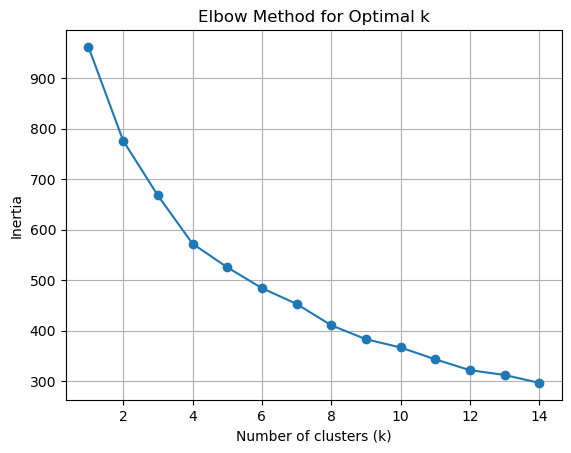

In [18]:
# elbow method
from sklearn.cluster import KMeans
X = data.copy()
inertia_values = []
for k in range(1, 15):
    model = KMeans(n_clusters=k, random_state=42)
    model.fit(X)
    inertia_values.append(model.inertia_)
plt.plot(range(1, 15), inertia_values, 'o-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [22]:
# consensus index method using ARI
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.cluster import KMeans

np.random.seed(0)

Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())

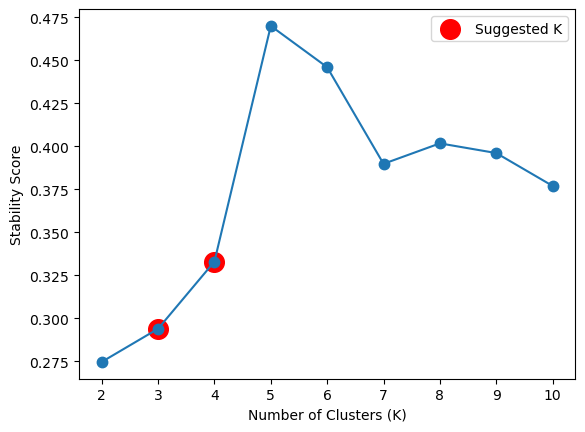

In [23]:
plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.scatter(
    [3, 4],
    [stability_scores[1], stability_scores[2]],
    s=200,
    color="red",
    label="Suggested K",
)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

_Answer_: add answer

### Question 4

In [ ]:
X = data.drop('labels', axis=1)
true_labels = data['labels']

# Test different k values with internal metrics
results = []
for k in range(2, 6):
    model = KMeans(n_clusters=k, random_state=42)
    pred_labels = model.fit_predict(X)
    
    results.append({
        'k': k,
        'Silhouette': silhouette_score(X, pred_labels),
        'ARI': adjusted_rand_score(true_labels, pred_labels)
    })

df = pd.DataFrame(results)
print(df.round(3))

# Find best k for each metric
best_sil = df.loc[df['Silhouette'].idxmax(), 'k']
best_ari = df.loc[df['ARI'].idxmax(), 'k']

print(f"\nBest k: Silhouette={best_sil}, ARI={best_ari}")
print(f"Internal matches external: {best_sil == best_ari}")

_Answer_: add answer

### Question 5

_Answer_: add answer

# Dataset 3

In [28]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/2wtandc0jofhw0i4ivh1v/dataset03.tsv?rlkey=jtv6zbpaw0c5v70kd73uj2ccs&st=mkv2zlzs&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions as for Dataset 2.

**In addition**, answer Question 7 below for this dataset.

### Question 1

In [ ]:
data.head()
#data.describe()
#data.info()
#data.shape

_Answer_: add answer

### Question 2

_Answer_: add answer

### Question 3

_Answer_: add answer

### Question 4

Internal Metrics Comparison:
   k  Silhouette  Calinski-Harabasz
0  2       0.323             82.581
1  3       0.435            133.212
2  4       0.465            168.891
3  5       0.425            171.811
4  6       0.445            205.259
5  7       0.466            222.510

Best k values:
Silhouette Score: 7
Calinski-Harabasz Index: 7

Do all internal metrics agree? True


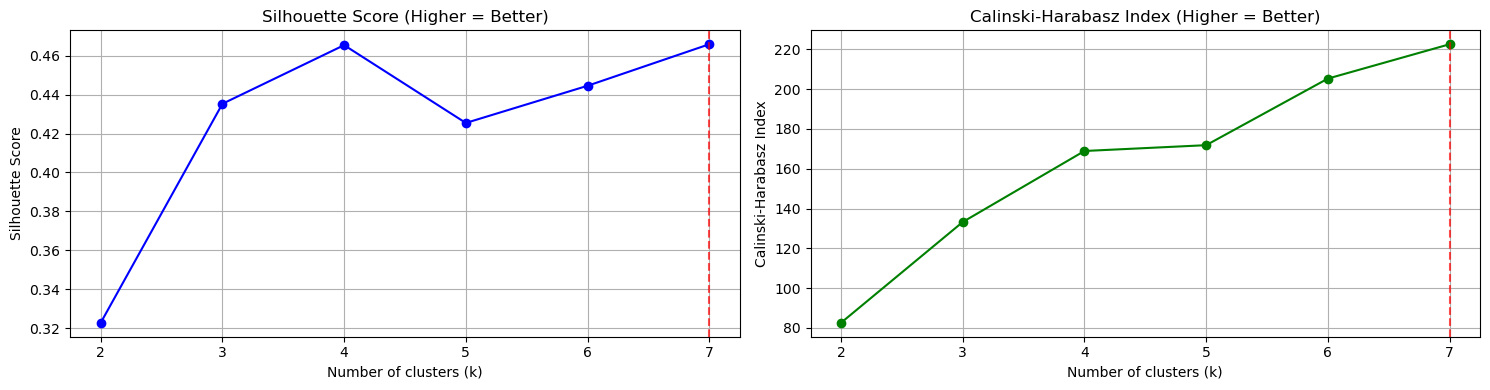

In [ ]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score

# Since Dataset 3 has no labels, we use only internal metrics
X = data.copy()

# Test different k values with multiple internal metrics
results = []
for k in range(2, 8):
    model = KMeans(n_clusters=k, random_state=42)
    pred_labels = model.fit_predict(X)
    
    results.append({
        'k': k,
        'Silhouette': silhouette_score(X, pred_labels),
        'Calinski-Harabasz': calinski_harabasz_score(X, pred_labels)
    })

df = pd.DataFrame(results)
print("Internal Metrics Comparison:")
print(df.round(3))

# find best k for each metric
best_sil = df.loc[df['Silhouette'].idxmax(), 'k']
best_ch = df.loc[df['Calinski-Harabasz'].idxmax(), 'k']

print(f"\nBest k values:")
print(f"Silhouette Score: {best_sil}")
print(f"Calinski-Harabasz Index: {best_ch}")

# check if metrics agree
metrics_agree = (best_sil == best_ch)
print(f"\nDo all internal metrics agree? {metrics_agree}")

if not metrics_agree:
    print("The metrics suggest different optimal k values.")

# visualize the metrics
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# silhouette Score 
axes[0].plot(df['k'], df['Silhouette'], 'o-', color='blue')
axes[0].set_title('Silhouette Score')
axes[0].set_xlabel('Number of clusters (k)')
axes[0].set_ylabel('Silhouette Score')
axes[0].grid(True)
axes[0].axvline(x=best_sil, color='red', linestyle='--', alpha=0.7)

# Ccalinski-Harabasz Index 
axes[1].plot(df['k'], df['Calinski-Harabasz'], 'o-', color='green')
axes[1].set_title('Calinski-Harabasz Index')
axes[1].set_xlabel('Number of clusters (k)')
axes[1].set_ylabel('Calinski-Harabasz Index')
axes[1].grid(True)
axes[1].axvline(x=best_ch, color='red', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

_Answer_: add answer

### Question 5

_Answer_: add answer

## Question 7

As you probably guessed after answering Question 5 (Dataset 3) and making the plot, this dataset has an unusual structure: it has two concentric circles (or rings).
It was generated using the function [`make_circles`](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html) from sklearn.
These complex datasets are used to test different clustering and classification algorithms with different degrees of difficulty.

So here you have the **first question**:
1. $K$-Means cannot capture this structure. Why not?

Now, let's try to answer Questions 3-5 but using different clustering algorithms and explore different parameters.
Some suggestions are:
* [Spectral Clustering](https://scikit-learn.org/1.5/modules/clustering.html#spectral-clustering):
  * It computes a low-dimensional embedding of the input data where the complex data structures (such as the rings) are more apparent. Then it applies $K$-Means on this embedding.
  * A suggestion on how to run it:

    ```python
        cluster.SpectralClustering(
            n_clusters=k, affinity="nearest_neighbors", n_init=1
        )
    ```

    You can try different parameters such as `affinity` or `gamma`.
* [DBSCAN](https://scikit-learn.org/1.5/modules/clustering.html#dbscan):
  * This algorithm is very different from $K$-Means. It is not centroid-based, but density-based. Some analyses, such as Consensus Index, are not directly applicable here.
  * The most important parameter is `eps`: make sure you use values around `0.30` for this dataset. One way to generate values in an interval is to use `np.linspace(0.20, 0.50, 100)`
  * A suggestion on how to run it:

    ```python
        model = cluster.DBSCAN(eps=eps_val)
    ```

* [Hierarchical clustering](https://scikit-learn.org/1.5/modules/clustering.html#hierarchical-clustering):
  * This is a classic algorithm, very popular.
  * In addition to returning a single, flat partition, hierarchical clustering can produce a hierarchy of partitions, where clusters are subsequently divided into smaller ones. This hierarchical structure might be very useful in particular problems where we expect this data structure.
  * The main parameter, in addition to the number of clusters, is the `linkage` criteria that determines how to merge clusters.

Then also answer these **other questions**:

2. Were you successful with a different clustering algorithm? Which one?
3. Why did the new algorithm work?

_Answer_: add answer

### Spectral Clustering

#### Question 3

#### Question 4

#### Question 5

### DBSCAN

#### Question 3

#### Question 4

#### Question 5

### Hierarchical Clustering

#### Question 3

#### Question 4

#### Question 5